# Welcome to the `U-Net` Workshop!
In this workshop, we'll build on the UNet_starter Notebook and build a full fledged Encoder-Decoder model, use it for Semantic Segmentation using Pytorch. We'll do the following tasks:

- **Dataset**: Download and use BDD100k dataset
- **Network**: Define U-Net model using Encoder-Decoder architecture
- **Training**: Train and validate model on the custom dataset
- **Evaluate**: Evaluate the model on Test Data and visualize results

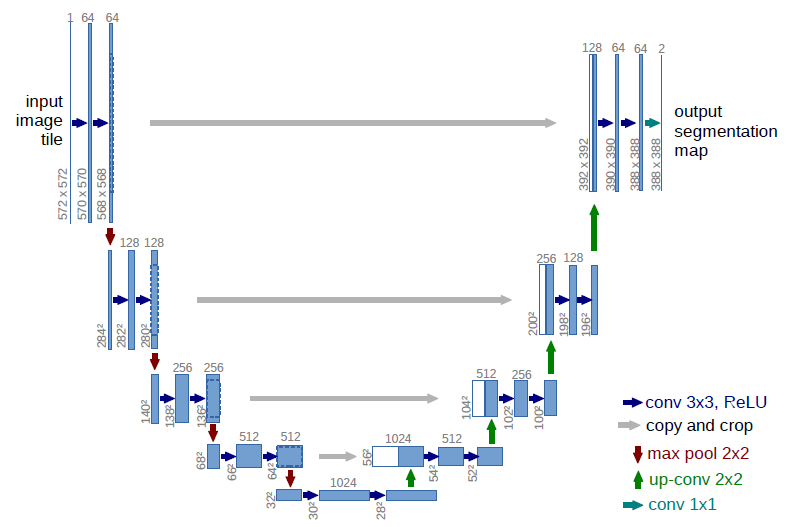

[Image reference](https://arxiv.org/abs/1505.04597)

## Imports

In [1]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segmentation.zip && unzip segmentation.zip && mv segmentation/* .

--2023-12-14 10:02:07--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segmentation.zip
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 52.95.154.102, 16.12.19.2
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|52.95.154.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1340691042 (1.2G) [application/zip]
Saving to: ‘segmentation.zip’

segmentation.zip    100%[===================>]   1.25G  59.1MB/s    in 22s     

2023-12-14 10:02:29 (58.8 MB/s) - ‘segmentation.zip’ saved [1340691042/1340691042]

Archive:  segmentation.zip
   creating: segmentation/
  inflating: __MACOSX/._segmentation  
  inflating: segmentation/.DS_Store  
  inflating: __MACOSX/segmentation/._.DS_Store  
   creating: segmentation/dataset/
  inflating: __MACOSX/segmentation/._dataset  
   creating: segmentation/weigh

In [2]:
# basic imports
import random
import numpy as np
from tqdm import tqdm

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting
import cv2
import matplotlib.pyplot as plt

- We'll also import "segmentation_models_pytorch" which is a library ([accessible here](https://github.com/qubvel/segmentation_models.pytorch) where you can have direct access to models like UNet, DeepLab, etc...)
- It contains segmentation model weights trained with different encoder and dataset combinations
- Very Useful to setup custom model quickly for own problem statement via ***Transfer Learning***

In [3]:
# try to import the library, if already present
# good to go, else install it and then import library
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a6f959e53cb94bcf50530dd4671771af484061f9687cc02f4b011465f1ef029e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3b54afa7e8edbada6acf65c7e18b3e928e5ea0e7f7dee4279c3a3d334e30f17f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


## 1. Dataset : Download and use BDD100k dataset

In [4]:
# load images and label data
images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")

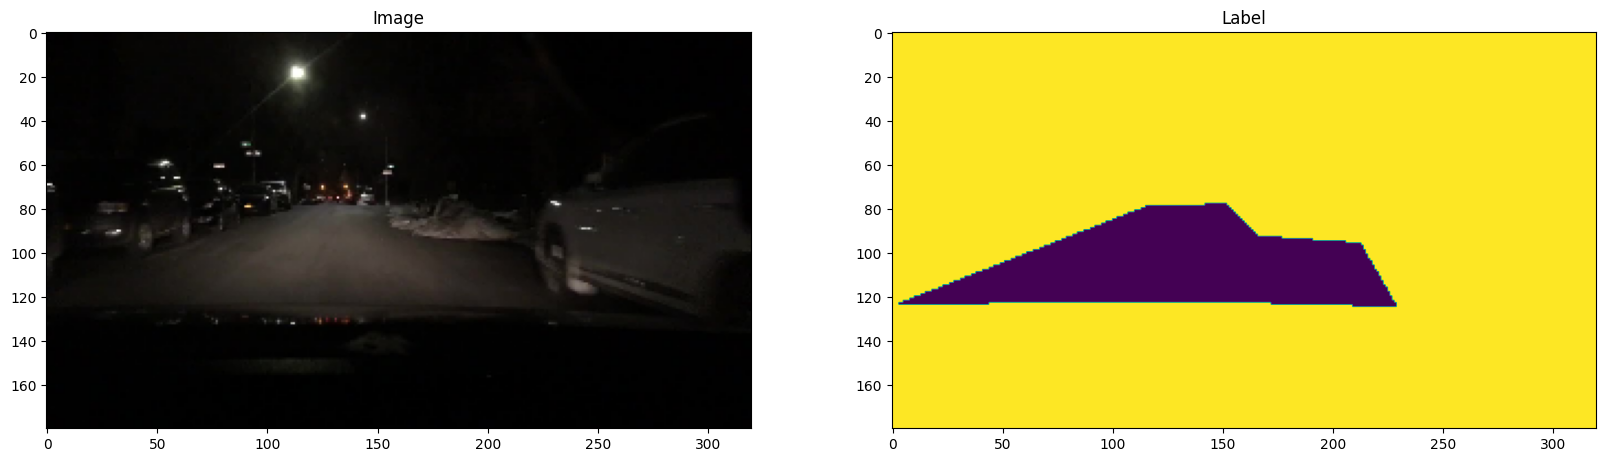

In [5]:
# plot sample image
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
ax0.imshow(images[458])    # random image number
ax0.set_title("Image")
ax1.imshow(labels[458])
ax1.set_title("Label")
plt.show()

### Class label to standard color maps

- Often, its better to have standard color mappings for each class label.
- Helps in readability and consistency across different experimets.
- [Cityscapes Dataset](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py) came up with a color mapping, which is pretty much standard across other datasets
- In our case, we'll define color mappings for the 3 classes - *Current lane, alternate lane and background*

In [6]:
# Constants for Standard color mapping
# reference : https://github.com/bdd100k/bdd100k/blob/master/bdd100k/label/label.py
from collections import namedtuple

# Each label is a tuple with name, class id and color
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [
             Label("direct", 0, (171, 44, 236)),        # red
             Label("alternative", 1, (86, 211, 19)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black
            ]

train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)
print(f"train_id_to_color = \n {train_id_to_color}")

train_id_to_color = 
 [[171  44 236]
 [ 86 211  19]
 [  0   0   0]]


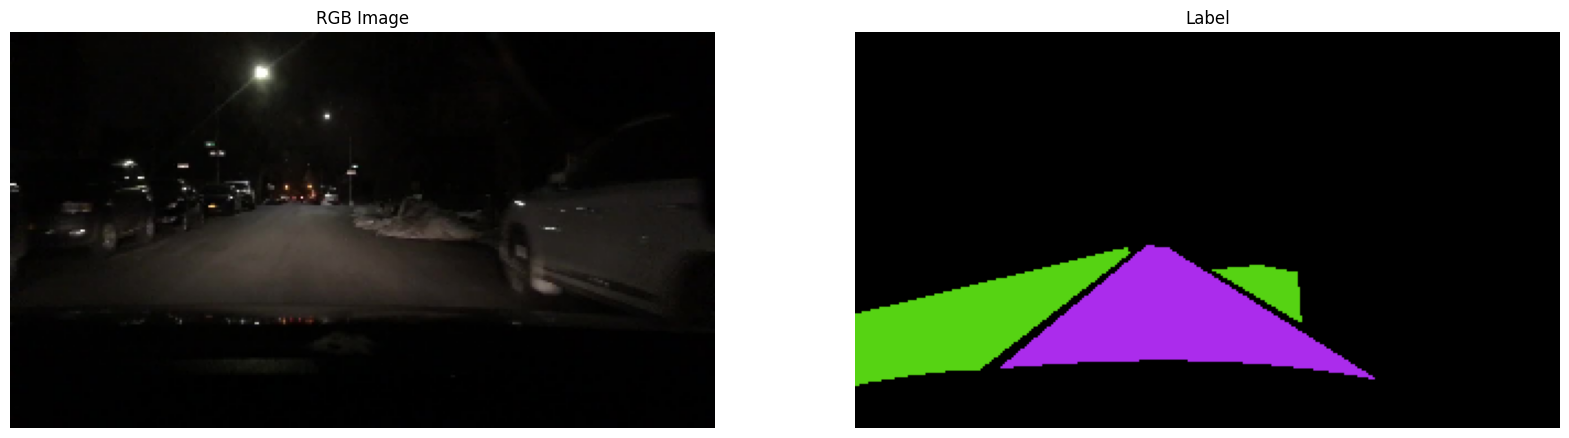

In [7]:
# plot sample image using defined color mappings
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(images[458]);
axes[0].set_title("RGB Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[labels[201]]);
axes[1].set_title("Label");
axes[1].axis('off');

### Build Datasets & DataLoaders
Every PyTorch model is built and train using 3 elements:

*   Dataset
*   DataLoader
*   Model



#### Dataset Class

- We'll define a custom Pytorch Dataset class for BDD100k_dataset drivable / segmentation data.
- The Dataset class should have at least `__len__()` and `__getitem__()` functions

In [8]:
from torch.utils.data import Dataset, DataLoader

class BDD100k_dataset(Dataset):
    def __init__(self, images, labels, tf):
        self.images = images
        self.labels = labels
        self.tf = tf

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        # read source image and convert to RGB, apply transform
        rgb_image = self.images[index]
        if self.tf is not None:
            rgb_image = self.tf(rgb_image)

        # read label image and convert to torch tensor
        label_image  = torch.from_numpy(self.labels[index]).long()
        return rgb_image, label_image

- Pytorch requires images in torch.Tensor format
- Also, need to normalize images to have zero mean pixel value and standard deviation of 1. **Helps in model learning faster and more robust**
- We'll use *reference mean and standard deviation from Imagenet dataset* in a **pytorch preprocessing transform**

In [9]:
from torchvision import transforms
preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

In [10]:
# Function to split data into train, validation and test sets
def get_datasets(images, labels):
    data = BDD100k_dataset(images, labels, tf=preprocess)
    total_count = len(data)
    train_count = int(0.7 * total_count)
    valid_count = int(0.2 * total_count)
    test_count = total_count - train_count - valid_count
    train_set, val_set, test_set = torch.utils.data.random_split(data,
                (train_count, valid_count, test_count), generator=torch.Generator().manual_seed(1))
    return train_set, val_set, test_set

#### Dataloaders

- Dataloaders help load data in batches
- We'll need to define separate dataloaders for training, validation and test sets



In [11]:
def get_dataloaders(train_set, val_set, test_set):
    train_dataloader = DataLoader(train_set, batch_size=8,drop_last=True)
    val_dataloader   = DataLoader(val_set, batch_size=8)
    test_dataloader  = DataLoader(test_set, batch_size=8)
    return train_dataloader, val_dataloader, test_dataloader


In [12]:
train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


### Show Sample images from dataset

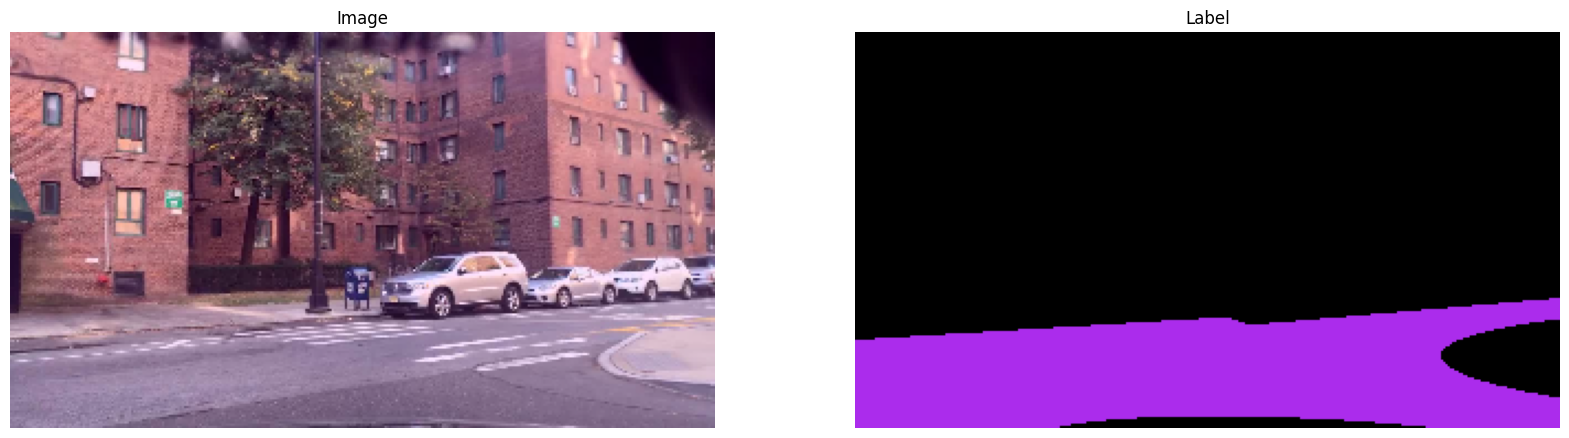

In [13]:
from utils import inverse_transform

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

## 2. Network: Define a UNet Encoder-Decoder
Pay close attention to the image, this is what we are going to code:
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Notice the 3 main elements:
* The Encoder
* The Decoder
* The Skip-Connections

### The Encoder
Notice how the encoder is made of these "double convolutions".
We have an input image, and then:

*   Two 3x3 Convolutions with ReLU
*   A 2x2 Max Pooling

That operation is repeated 4 times, as shown on the iPad.

**So let's implement this double convolutional block!** — Because this double convolution operation is repeated also later without Pooling, we'll leave pooling out and implement it later.

##### How to create a model with PyTorch
With PyTorch, you always need to have a class with 2 elements:
* An __init__() function, where you define the convolutions, etc...
* A **forward()** function, where you define in which order the elements are going to be called.
<p>

See it like a salad; you first define your ingredients and get them out of the fridge (this is the Init function) and only then will you write a recipe with the elements you have (this is the forward function).

This is one element of the encoder, the other is pooling. So how does that work together?

In [14]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

In [15]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, layer_channels):
        super(UNetEncoder, self).__init__()
        self.encoder = nn.ModuleList()

        # Double Convolution
        for num_channels in layer_channels:
            self.encoder.append(double_conv(in_channels, num_channels))
            in_channels = num_channels

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self):
        # Pass input image through Encoder
        for down in self.encoder:
            x = down(x)
            x = self.pool(x)
        return x

So, we have built the UNet Encoder; notice how we can now add a fully-connected layer and it would become a classification network!

But we're not gonna do that! Instead, we're going to implement a **Decoder**!
### The Decoder
The upsampling part is made through a series of 4:
* **One Transposed 2x2 Convolution**
* **A Double 3x3 Convolution with ReLU** (as in the encoder)

Finally, the model has **a final 1x1 convolution that classifies every single pixel**!

In [16]:
import torchvision.transforms.functional as TF

class UNetDecoder(nn.Module):
    def __init__(self, layer_channels):
        super(UNetDecoder, self).__init__()
        self.decoder = nn.ModuleList()

        # Decoder layer Double Convolution blocks
        # and upsampling blocks
        self.decoder = nn.ModuleList()
        for num_channels in reversed(layer_channels):
            # upsample output and reduce channels by 2
            self.decoder.append(nn.ConvTranspose2d(num_channels*2, num_channels, kernel_size=2, stride=2))
            self.decoder.append(double_conv(num_channels, num_channels))

    def forward(self, x):
        for up in self.decoder:
            x = up(x)
        return x

Alright! We have an Encoder-Decoder Architecture! But we ain't finished yet, we still to add those skip_connections!

### The Final UNet Architecture (with Skip-Connections)


In [17]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, layer_channels):
        super(UNetEncoder, self).__init__()
        self.encoder = nn.ModuleList()

        # Double Convolution blocks
        for num_channels in layer_channels:
            self.encoder.append(double_conv(in_channels, num_channels))
            in_channels = num_channels

        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Pass input image through Encoder blocks
        # and return outputs at each stage
        skip_connections = []
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        return x, skip_connections


class UNetDecoder(nn.Module):
    def __init__(self, layer_channels):
        super(UNetDecoder, self).__init__()
        self.decoder = nn.ModuleList()

        # Decoder layer Double Convolution blocks
        # and upsampling blocks
        self.decoder = nn.ModuleList()
        for num_channels in reversed(layer_channels):
            self.decoder.append(nn.ConvTranspose2d(num_channels*2, num_channels, kernel_size=2, stride=2))
            self.decoder.append(double_conv(num_channels*2, num_channels))


    def forward(self, x, skip_connections):
        for idx in range(0, len(self.decoder), 2):
            # upsample output and reduce channels by 2
            x = self.decoder[idx](x)

            # if skip connection shape doesn't match, resize
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # concatenate and pass through double_conv block
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)
        return x



class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, layer_channels):
        super(UNet, self).__init__()

        # Encoder and decoder modules
        self.encoder = UNetEncoder(in_channels, layer_channels)
        self.decoder = UNetDecoder(layer_channels)

        # conv layer to transition from encoder to decoder and
        # 1x1 convolution to reduce num channels to out_channels
        self.bottleneck = double_conv(layer_channels[-1], layer_channels[-1]*2)
        self.final_conv = nn.Conv2d(layer_channels[0], out_channels, kernel_size=1)

        # initialize parameters now to avoid modifying the initialization of top_blocks
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                # nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder blocks
        encoder_output, skip_connections = self.encoder(x)

        # transition between encoder and decoder
        x = self.bottleneck(encoder_output)

        # we need the last skip connection first
        # so reversing the list
        skip_connections = skip_connections[::-1]

        # Decoder blocks
        x = self.decoder(x, skip_connections)

        # final 1x1 conv to match input size
        return self.final_conv(x)

Nice work! Let's now train this model!

## 3. Training : Train and validate model on the custom dataset

In [18]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

### Hyperparameters

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 50
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'UNet_baseline'

# create model, optimizer, lr_scheduler and pass to training function
model = UNet(in_channels=3, out_channels=3, layer_channels=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

### How to train a model with PyTorch

Here's the structure of a training loop in PyTorch:

**1) LOOP THROUGH THE DATALOADER N_EPOCH TIMES**
```python
    for epoch in range(num_epochs):        
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
```
**2) FORWARD PASS**
```python
            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
```
**3) BACKWARD PASS**
```python
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()

```
**4) RUN ON THE TEST DATASET**
```python       
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, num_classes, device)
```
A note — We have another function call here, the evaluate_model() function is actually running its own forward pass, but on the dataset. You can find it on the **utils.py** file, section evaluate_model().<p>
**5) STORE & SHOW RESULTS**
```python
        results.append({'epoch': epoch,
                        'trainLoss': train_loss,
                        'validationLoss': validation_loss,
                        f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{output_path}/{model_name}.pt")
            # torch.jit.save(torch.jit.script(model), f"{output_path}/{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

```

You can find the entire training pipeline in the **utils.py** file — function **train_evaluate_model()**.

In [20]:
output_path = "dataset"

Starting 1 epoch ...


  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 86/86 [00:22<00:00,  3.81it/s]


Epoch: 1, trainLoss:1.09834, validationLoss:0.80112, meanIoU: 0.49
Starting 2 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.95it/s]


Epoch: 2, trainLoss:0.69150, validationLoss:0.69501, meanIoU: 0.55
Starting 3 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.82it/s]


Epoch: 3, trainLoss:0.55548, validationLoss:0.63334, meanIoU: 0.57
Starting 4 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.85it/s]


Epoch: 4, trainLoss:0.45171, validationLoss:0.54759, meanIoU: 0.57
Starting 5 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 5, trainLoss:0.39357, validationLoss:0.49754, meanIoU: 0.60
Starting 6 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.83it/s]


Epoch: 6, trainLoss:0.36797, validationLoss:0.54546, meanIoU: 0.59
Starting 7 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.82it/s]


Epoch: 7, trainLoss:0.32714, validationLoss:0.47689, meanIoU: 0.61
Starting 8 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 8, trainLoss:0.29708, validationLoss:0.39360, meanIoU: 0.63
Starting 9 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.85it/s]


Epoch: 9, trainLoss:0.28997, validationLoss:0.48813, meanIoU: 0.62
Starting 10 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.63it/s]


Epoch: 10, trainLoss:0.28375, validationLoss:0.44440, meanIoU: 0.62
Starting 11 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.78it/s]


Epoch: 11, trainLoss:0.27825, validationLoss:0.44888, meanIoU: 0.63
Starting 12 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.74it/s]


Epoch: 12, trainLoss:0.26162, validationLoss:0.36507, meanIoU: 0.65
Starting 13 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.91it/s]


Epoch: 13, trainLoss:0.25002, validationLoss:0.44404, meanIoU: 0.64
Starting 14 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.73it/s]


Epoch: 14, trainLoss:0.25338, validationLoss:0.35092, meanIoU: 0.67
Starting 15 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.84it/s]


Epoch: 15, trainLoss:0.23117, validationLoss:0.45036, meanIoU: 0.62
Starting 16 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.85it/s]


Epoch: 16, trainLoss:0.21792, validationLoss:0.45921, meanIoU: 0.65
Starting 17 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.75it/s]


Epoch: 17, trainLoss:0.20414, validationLoss:0.38363, meanIoU: 0.66
Starting 18 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 18, trainLoss:0.20085, validationLoss:0.45665, meanIoU: 0.64
Starting 19 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Epoch: 19, trainLoss:0.19791, validationLoss:0.30658, meanIoU: 0.68
Starting 20 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.77it/s]


Epoch: 20, trainLoss:0.18407, validationLoss:0.38827, meanIoU: 0.66
Starting 21 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.88it/s]


Epoch: 21, trainLoss:0.17394, validationLoss:0.38984, meanIoU: 0.66
Starting 22 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Epoch: 22, trainLoss:0.17316, validationLoss:0.31166, meanIoU: 0.66
Starting 23 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 23, trainLoss:0.16216, validationLoss:0.37266, meanIoU: 0.68
Starting 24 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Epoch: 24, trainLoss:0.14207, validationLoss:0.38948, meanIoU: 0.68
Starting 25 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.90it/s]


Epoch: 25, trainLoss:0.13825, validationLoss:0.37903, meanIoU: 0.67
Starting 26 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Epoch: 26, trainLoss:0.12440, validationLoss:0.40420, meanIoU: 0.68
Starting 27 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.88it/s]


Epoch: 27, trainLoss:0.11850, validationLoss:0.34505, meanIoU: 0.68
Starting 28 epoch ...


100%|██████████| 86/86 [00:24<00:00,  3.58it/s]


Epoch: 28, trainLoss:0.11406, validationLoss:0.36419, meanIoU: 0.67
Starting 29 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Epoch: 29, trainLoss:0.11333, validationLoss:0.32636, meanIoU: 0.69
Starting 30 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.89it/s]


Epoch: 30, trainLoss:0.10195, validationLoss:0.37450, meanIoU: 0.69
Starting 31 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.81it/s]


Epoch: 31, trainLoss:0.09571, validationLoss:0.37561, meanIoU: 0.69
Starting 32 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.93it/s]


Epoch: 32, trainLoss:0.09341, validationLoss:0.41231, meanIoU: 0.68
Starting 33 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.78it/s]


Epoch: 33, trainLoss:0.08527, validationLoss:0.39741, meanIoU: 0.68
Starting 34 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Epoch: 34, trainLoss:0.08245, validationLoss:0.37257, meanIoU: 0.69
Starting 35 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.94it/s]


Epoch: 35, trainLoss:0.07675, validationLoss:0.32596, meanIoU: 0.70
Starting 36 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.80it/s]


Epoch: 36, trainLoss:0.07156, validationLoss:0.39845, meanIoU: 0.69
Starting 37 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.80it/s]


Epoch: 37, trainLoss:0.06827, validationLoss:0.34853, meanIoU: 0.69
Starting 38 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.95it/s]


Epoch: 38, trainLoss:0.06559, validationLoss:0.37132, meanIoU: 0.70
Starting 39 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.78it/s]


Epoch: 39, trainLoss:0.06063, validationLoss:0.38336, meanIoU: 0.69
Starting 40 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.87it/s]


Epoch: 40, trainLoss:0.05791, validationLoss:0.34058, meanIoU: 0.70
Starting 41 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.86it/s]


Epoch: 41, trainLoss:0.05544, validationLoss:0.34698, meanIoU: 0.70
Starting 42 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.81it/s]


Epoch: 42, trainLoss:0.05312, validationLoss:0.32719, meanIoU: 0.70
Starting 43 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.92it/s]


Epoch: 43, trainLoss:0.05142, validationLoss:0.31460, meanIoU: 0.71
Starting 44 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.83it/s]


Epoch: 44, trainLoss:0.04947, validationLoss:0.30759, meanIoU: 0.71
Starting 45 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.70it/s]


Epoch: 45, trainLoss:0.04812, validationLoss:0.30689, meanIoU: 0.71
Starting 46 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.66it/s]


Epoch: 46, trainLoss:0.04698, validationLoss:0.30662, meanIoU: 0.71
Starting 47 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.86it/s]


Epoch: 47, trainLoss:0.04617, validationLoss:0.30592, meanIoU: 0.71
Starting 48 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.82it/s]


Epoch: 48, trainLoss:0.04559, validationLoss:0.30472, meanIoU: 0.71
Starting 49 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.71it/s]


Epoch: 49, trainLoss:0.04524, validationLoss:0.30499, meanIoU: 0.71
Starting 50 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.85it/s]


Epoch: 50, trainLoss:0.04505, validationLoss:0.30545, meanIoU: 0.71


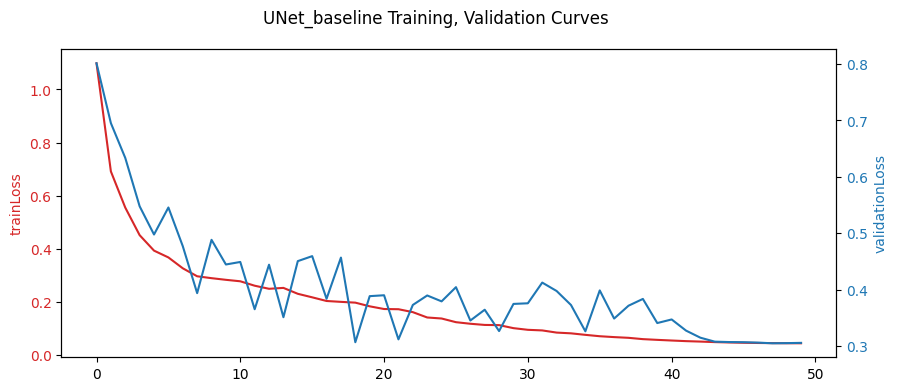

In [21]:
_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

# 4. Evaluate : Evaluate the model on Test Data and visualize results

In [22]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 43/43 [00:11<00:00,  3.91it/s]


Model has 0.7275733100247107 mean IoU in test set


In [23]:
from utils import visualize_predictions

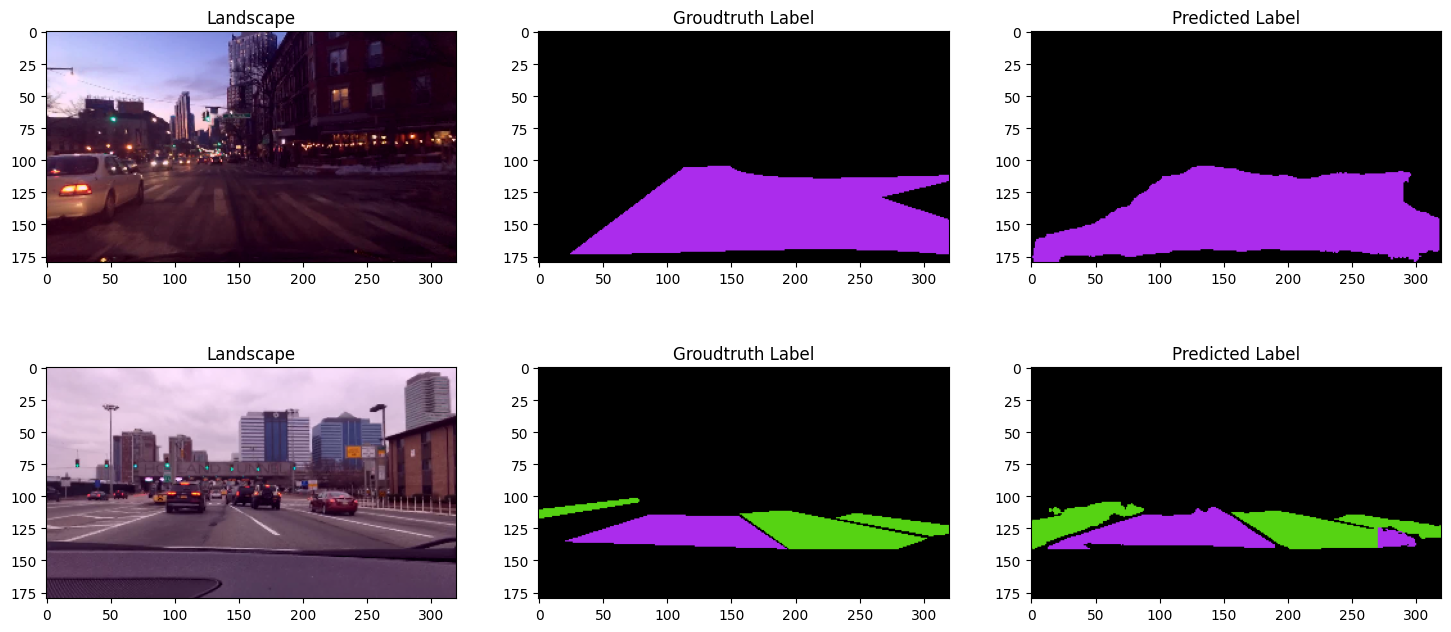

In [24]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

## Test on sample video

If you want to test it on a real video, you can try:

```python
from utils import predict_video
predict_video(model, model_name, input_video_path, output_dir,
            target_width, target_height, device)
```

In out case, we'll have several videos we can try our model on:
* Highway (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi`
* Residential (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/residential_1242_375.avi`
* Campus (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/campus_1224_370.avi`
* Stuttgart (Cityscapes)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/stuttgart_1024_512.avi`

So let's try with the highway:

In [25]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi

--2023-12-14 12:08:42--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 52.95.156.60, 3.5.224.142
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|52.95.156.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55440936 (53M) [video/x-msvideo]
Saving to: ‘highway_1241_376.avi’

highway_1241_376.av 100%[===================>]  52.87M  60.1MB/s    in 0.9s    

2023-12-14 12:08:43 (60.1 MB/s) - ‘highway_1241_376.avi’ saved [55440936/55440936]



And run our function:

In [ ]:
from utils import predict_video
predict_video(model, "Unet5epochs", "highway_1241_376.avi", "segmentation", 1241, 376, "cuda", train_id_to_color)

If you look at the results, you'll notice they aren't good! And the reason is, the model has been trained on a specific resolution (180x360), but the input video is on a totally different resolution. For example, the highway video is 1241x376.

**For a portfolio video, you want to have a model that can process higher resolution images.**
Let's try to load videos converted to 360x640 resolution, and let's download 360x640 weights specifically created for the occasion!

In [27]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/360_640/UNet_baseline.pt && mv UNet_baseline.pt weights/360_640/UNet_baseline.pt

--2023-12-14 12:12:04--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/360_640/UNet_baseline.pt
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 3.5.224.123, 3.5.225.18
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|3.5.224.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124237717 (118M) [application/x-www-form-urlencoded]
Saving to: ‘UNet_baseline.pt’

UNet_baseline.pt    100%[===================>] 118.48M  59.5MB/s    in 2.0s    

2023-12-14 12:12:06 (59.5 MB/s) - ‘UNet_baseline.pt’ saved [124237717/124237717]



Next, we reload the model weights. This is done with the PyTorch **.load()** function

In [ ]:
output_path="weights/360_640"
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))

And rerun our predict function on the new video. For example, the Stuttgart video (1024x512) has the same 2:1 ratio than what the model was trained on.

In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/360_640/stuttgart_1024_512_360_640.avi

In [ ]:
predict_video(model, "UnetHQ", "stuttgart_1024_512_360_640.avi", "segmentation", 640, 360, "cuda", train_id_to_color)